In [33]:
import re
import unicodedata
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

import acquire as a
import prepare as p

from wordcloud import WordCloud

from env import user, password, host

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'


url = get_db_url("spam_db")
sql = "SELECT * FROM spam"

## 1. Spam Data

### a. Load the spam data set.

In [3]:
df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [5]:
ham_words = clean(' '.join(df[df.label == 'ham']['text']))
spam_words = clean(' '.join(df[df.label == 'spam']['text']))
all_words = clean(' '.join(df['text']))

In [6]:
len(all_words), len(spam_words), len(ham_words)

(50305, 12163, 38142)

In [7]:
ham_words

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'oni',
 'dun',
 'say',
 'early',
 'hor',
 'c',
 'already',
 'say',
 'nah',
 'dont',
 'think',
 'go',
 'usf',
 'life',
 'around',
 'though',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aid',
 'patent',
 'per',
 'request',
 'melle',
 'melle',
 'oru',
 'minnaminunginte',
 'nurungu',
 'vettam',
 'set',
 'callertune',
 'caller',
 'press',
 '9',
 'copy',
 'friend',
 'callertune',
 'im',
 'gonna',
 'home',
 'soon',
 'dont',
 'want',
 'talk',
 'stuff',
 'anymore',
 'tonight',
 'k',
 'ive',
 'cried',
 'enough',
 'today',
 'ive',
 'searching',
 'right',
 'word',
 'thank',
 'breather',
 'promise',
 'wont',
 'take',
 'help',
 'granted',
 'fulfil',
 'promise',
 'wonderful',
 'blessing',
 'time',
 'date',
 'sunday',
 'oh',
 'kim',
 'watching',
 'eh',
 'remember',
 'spell',
 'name',
 'yes',
 'v',
 'naught

In [13]:
ham_bigrams = pd.Series(nltk.bigrams(ham_words))
spam_bigrams = pd.Series(nltk.bigrams(spam_words))

In [14]:
top_20_ham_bigrams = ham_bigrams.value_counts().head(20)

In [15]:
top_20_spam_bigrams = spam_bigrams.value_counts().head(20)

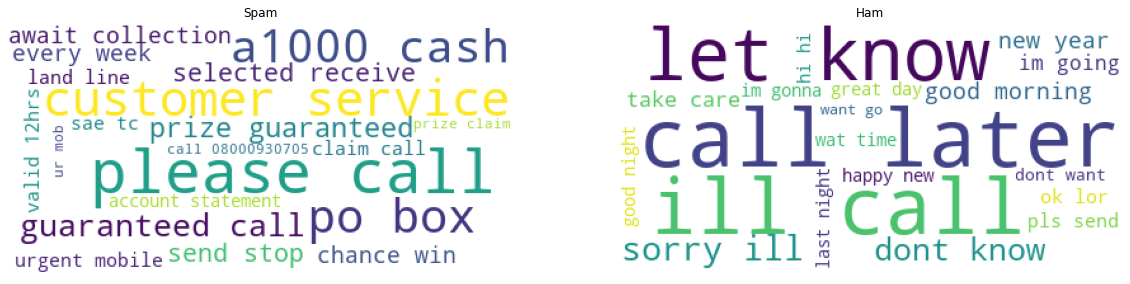

In [16]:
spam_data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
spam_cloud = WordCloud(background_color='white').generate_from_frequencies(spam_data)

ham_data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
ham_cloud = WordCloud(background_color='white').generate_from_frequencies(ham_data)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,15))

ax1.imshow(spam_cloud)
ax1.axis('off')
ax1.set_title('Spam')

ax2.imshow(ham_cloud)
ax2.axis('off')
ax2.set_title('Ham')

plt.show()

### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [18]:
spam_freq = spam_bigrams.value_counts()
ham_freq = ham_bigrams.value_counts()

In [21]:
bigram_counts = (pd.concat([ham_freq, spam_freq], axis=1, sort=True)
                .set_axis([ 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))


In [25]:
bigram_counts.sort_values(by=['spam','ham'], ascending=[False, True])

,,ham,spam
please,call,9,44
customer,service,2,27
po,box,1,24
a1000,cash,0,23
guaranteed,call,0,23
...,...,...,...
good,morning,31,0
sorry,ill,39,0
let,know,42,0
ill,call,48,0


### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

In [26]:
spam_trigrams = pd.Series(nltk.ngrams(spam_words, 3))
ham_trigrams = pd.Series(nltk.ngrams(ham_words, 3))
all_trigrams = pd.Series(nltk.ngrams(all_words, 3))
# frequencies
spam_freq3 = spam_trigrams.value_counts()
ham_freq3 = ham_trigrams.value_counts()
all_freq3 = all_trigrams.value_counts()

# top_20
top_20_spam_trigrams = spam_trigrams.value_counts().head(20)
top_20_ham_trigrams = ham_trigrams.value_counts().head(20)
top_20_all_trigrams = all_trigrams.value_counts().head(20)

In [27]:
# check overlaps
trigram_counts = (pd.concat([all_freq3, ham_freq3, spam_freq3], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))



,,,all,ham,spam
ill,call,later,42,42,0
sorry,ill,call,38,38,0
prize,guaranteed,call,21,0,21
happy,new,year,19,19,0
call,customer,service,15,0,15
reply,call,08000930705,14,0,14
land,line,claim,14,0,14
private,2003,account,13,0,13
2003,account,statement,13,0,13
pls,send,message,13,13,0


In [28]:
trigram_counts.sort_values(by=['spam','ham'], ascending=[False, True])

,,,all,ham,spam
prize,guaranteed,call,21,0,21
call,customer,service,15,0,15
land,line,claim,14,0,14
reply,call,08000930705,14,0,14
2003,account,statement,13,0,13
...,...,...,...,...,...
right,pls,send,12,12,0
pls,send,message,13,13,0
happy,new,year,19,19,0
sorry,ill,call,38,38,0


## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [30]:
blog = a.get_blog_articles_data()

In [31]:
blog

,title,content
0,Become a Data Scientist in 6 Months!,Are you feeling unfulfilled in your work but w...
1,Hiring Tech Talent Around the Holidays,Are you a hiring manager having trouble fillin...
2,Cloud Administration Program New Funding Options,Finding resources to fund your educational goa...
3,Why Dallas is a Great Location for IT Professi...,"When breaking into a new career, it is importa..."
4,Codeup is ranked #1 Best in DFW 2022,We are excited to announce that Codeup ranked ...
5,Codeup’s Scholarship Offerings,In honor of November being National Scholarshi...


In [34]:
clean_blog = p.prep_article_data(blog, 'content')

In [35]:
clean_blog

,title,content,clean,stemmed,lemmatized
0,Become a Data Scientist in 6 Months!,Are you feeling unfulfilled in your work but w...,feeling unfulfilled work want avoid returning ...,feel unfulfil work want avoid return tradit ed...,feeling unfulfilled work want avoid returning ...
1,Hiring Tech Talent Around the Holidays,Are you a hiring manager having trouble fillin...,hiring manager trouble filling position around...,hire manag troubl fill posit around holiday co...,hiring manager trouble filling position around...
2,Cloud Administration Program New Funding Options,Finding resources to fund your educational goa...,finding resources fund educational goals possi...,find resourc fund educ goal possibl largest ob...,finding resource fund educational goal possibl...
3,Why Dallas is a Great Location for IT Professi...,"When breaking into a new career, it is importa...",breaking new career important explore job oppo...,break new career import explor job opportun ex...,breaking new career important explore job oppo...
4,Codeup is ranked #1 Best in DFW 2022,We are excited to announce that Codeup ranked ...,excited announce codeup ranked 1 best tradetec...,excit announc codeup rank 1 best tradetechn sc...,excited announce codeup ranked 1 best tradetec...
5,Codeup’s Scholarship Offerings,In honor of November being National Scholarshi...,honor november national scholarship month wed ...,honor novemb nation scholarship month wed like...,honor november national scholarship month wed ...


In [42]:
words = ' '.join(clean_blog.lemmatized).split()

In [43]:
blog_bigrams = pd.Series(nltk.bigrams(words))

In [44]:
top_20_blog_bigrams = blog_bigrams.value_counts().head(20)

In [45]:
top_20_blog_bigrams

(middle, state)               8
(career, tech)                7
(scholarship, scholarship)    7
(scholarship, open)           6
(data, science)               5
(youll, learn)                5
(bootcamp, texas)             5
(financial, aid)              5
(new, job)                    5
(employer, partner)           5
(gi, bill)                    5
(get, started)                5
(19104, 267)                  4
(started, give)               4
(give, u)                     4
(career, technology)          4
(sure, career)                4
(arent, sure)                 4
(market, street)              4
(3624, market)                4
dtype: int64

In [46]:
blog_data

{'middle state': 8,
 'career tech': 7,
 'scholarship scholarship': 7,
 'scholarship open': 6,
 'data science': 5,
 'youll learn': 5,
 'bootcamp texas': 5,
 'financial aid': 5,
 'new job': 5,
 'employer partner': 5,
 'gi bill': 5,
 'get started': 5,
 '19104 267': 4,
 'started give': 4,
 'give u': 4,
 'career technology': 4,
 'sure career': 4,
 'arent sure': 4,
 'market street': 4,
 '3624 market': 4}

(-0.5, 399.5, 199.5, -0.5)

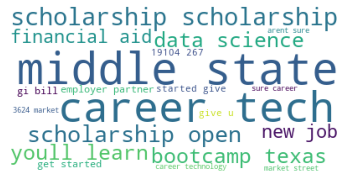

In [48]:
blog_data = {k[0] + ' ' + k[1]: v for k, v in top_20_blog_bigrams.to_dict().items()}

img = WordCloud(background_color='white').generate_from_frequencies(blog_data)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [53]:
news = a.get_news_articles_data()

In [54]:
news

,title,content,category
0,"'Mr India' cinematographer Peter Pereira, who ...",Veteran cinematographer and special effects pr...,national
1,Ashneer promises Mercedes cars to staff on com...,BharatPe's former Managing Director Ashneer Gr...,national
2,"Woman, fiance beaten up by bouncers at Gurugra...",A woman and her fiance suffered injuries after...,national
3,"NOCs of over 2,000 CBSE schools in Maha to be ...",Maharashtra Education Commissioner Suraj Mandh...,national
4,"When coach asked me to pad up vs Pak, the feel...",Indian hockey goalkeeper PR Sreejesh recalled ...,national
...,...,...,...
295,German Foreign Minister Annalena Baerbock visi...,German Foreign Minister Annalena Baerbock on T...,automobile
296,24 aid workers go on trial in Greece for 'faci...,The trial of 24 aid workers who helped rescue ...,automobile
297,Court acquits Austria's ex-Vice Chancellor in ...,A court in Austria on Tuesday acquitted the co...,automobile
298,Fed has only limited role to play on climate c...,US Federal Reserve Chair Jerome Powell said th...,automobile


In [55]:
clean_news = p.prep_article_data(news, 'content')

In [56]:
clean_news

,title,content,clean,stemmed,lemmatized
0,"'Mr India' cinematographer Peter Pereira, who ...",Veteran cinematographer and special effects pr...,veteran cinematographer special effects provid...,veteran cinematograph special effect provid pe...,veteran cinematographer special effect provide...
1,Ashneer promises Mercedes cars to staff on com...,BharatPe's former Managing Director Ashneer Gr...,bharatpe ' former managing director ashneer gr...,bharatp ' former manag director ashneer grover...,bharatpe ' former managing director ashneer gr...
2,"Woman, fiance beaten up by bouncers at Gurugra...",A woman and her fiance suffered injuries after...,woman fiance suffered injuries allegedly beate...,woman fianc suffer injuri allegedli beaten bou...,woman fiance suffered injury allegedly beaten ...
3,"NOCs of over 2,000 CBSE schools in Maha to be ...",Maharashtra Education Commissioner Suraj Mandh...,maharashtra education commissioner suraj mandh...,maharashtra educ commission suraj mandhar tues...,maharashtra education commissioner suraj mandh...
4,"When coach asked me to pad up vs Pak, the feel...",Indian hockey goalkeeper PR Sreejesh recalled ...,indian hockey goalkeeper pr sreejesh recalled ...,indian hockey goalkeep pr sreejesh recal first...,indian hockey goalkeeper pr sreejesh recalled ...
...,...,...,...,...,...
295,German Foreign Minister Annalena Baerbock visi...,German Foreign Minister Annalena Baerbock on T...,german foreign minister annalena baerbock tues...,german foreign minist annalena baerbock tuesda...,german foreign minister annalena baerbock tues...
296,24 aid workers go on trial in Greece for 'faci...,The trial of 24 aid workers who helped rescue ...,trial 24 aid workers helped rescue migrants co...,trial 24 aid worker help rescu migrant coast g...,trial 24 aid worker helped rescue migrant coas...
297,Court acquits Austria's ex-Vice Chancellor in ...,A court in Austria on Tuesday acquitted the co...,court austria tuesday acquitted country ' exvi...,court austria tuesday acquit countri ' exvic c...,court austria tuesday acquitted country ' exvi...
298,Fed has only limited role to play on climate c...,US Federal Reserve Chair Jerome Powell said th...,us federal reserve chair jerome powell said fe...,us feder reserv chair jerom powel said fed lim...,u federal reserve chair jerome powell said fed...


In [57]:
news_words = ' '.join(clean_news.lemmatized).split()

In [58]:
news_bigrams = pd.Series(nltk.bigrams(news_words))

In [59]:
top_20_news_bigrams = news_bigrams.value_counts().head(20)

In [60]:
top_20_news_bigrams

(said, added)                 48
(underconstruction, metro)    36
(delhi, witnessed)            36
(metro, pillar)               36
(aid, worker)                 36
(died, underconstruction)     36
(league, cup)                 24
(cm, basavaraj)               24
(karnataka, cm)               24
(cold, wave)                  24
(high, duty)                  24
(cross, 10)                   24
(official, said)              24
(nath, said)                  24
(manchester, city)            24
(said, ')                     24
(', ')                        24
(panic, button)               24
(foreign, minister)           24
(powell, said)                24
dtype: int64

(-0.5, 399.5, 199.5, -0.5)

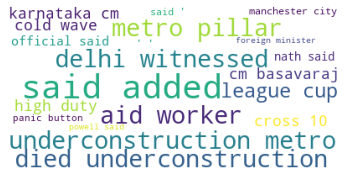

In [62]:
news_data = {k[0] + ' ' + k[1]: v for k, v in top_20_news_bigrams.to_dict().items()}

img2 = WordCloud(background_color='white').generate_from_frequencies(news_data)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img2)
# axis aren't very useful for a word cloud
plt.axis('off')